# 🔍 Détection de Fraude par Carte de Crédit - Version Améliorée

## Corrections méthodologiques apportées :
1. **Data Leakage corrigé** : Feature engineering APRÈS le split train/test
2. **Pas de features qui encodent la cible** : Suppression de `risk_score`, `multiple_risks`, etc.
3. **Validation croisée stratifiée** (5-Fold) pour évaluation robuste
4. **Gestion du déséquilibre** via sous-échantillonnage + class_weight
5. **Hyperparameter tuning** avec RandomizedSearchCV
6. **Courbes d'apprentissage** pour diagnostiquer biais/variance
7. **Intervalles de confiance** sur les métriques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, 
    RandomizedSearchCV, learning_curve, cross_validate
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    VotingClassifier, AdaBoostClassifier, BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, matthews_corrcoef,
    precision_score, recall_score, accuracy_score, average_precision_score
)
from scipy import stats

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
print(" Toutes les bibliothèques importées avec succès")

 Toutes les bibliothèques importées avec succès


## 1. Chargement et Exploration des Données

### 📊 Contexte Business
Les pertes mondiales dues à la fraude par carte de crédit dépassent **32 milliards de dollars** par an.  
Le défi : détecter les fraudes en temps réel tout en minimisant les faux positifs.

In [2]:
# ============================================================
# OPTION 1 : Charger votre fichier CSV (décommenter la ligne ci-dessous)
# ============================================================
# df = pd.read_csv('credit_card.csv')

# ============================================================
# OPTION 2 : Générer un dataset synthétique réaliste
# (utilisé ici car le CSV n'est pas disponible)
# ============================================================
np.random.seed(42)
n_total = 3075
n_fraud = 448
n_legit = n_total - n_fraud

def generate_legit(n):
    data = {
        'actionnr': np.arange(1, n+1),
        'merchant_id': np.random.randint(10000, 99999, n),
        'average_amount_transaction_day': np.random.uniform(4, 500, n),
        'transaction_amount': np.abs(np.random.lognormal(mean=7.5, sigma=1.2, size=n)),
        'is_declined': np.random.choice(['N', 'Y'], n, p=[0.98, 0.02]),
        'total_number_of_declines_day': np.random.choice([0,1,2], n, p=[0.85, 0.10, 0.05]),
        'isforeigntransaction': np.random.choice(['N', 'Y'], n, p=[0.85, 0.15]),
        'ishighriskcountry': np.random.choice(['N', 'Y'], n, p=[0.95, 0.05]),
        'daily_chargeback_avg_amt': np.abs(np.random.exponential(5, n)),
        'sixmonth_avg_chbk_amt': np.abs(np.random.exponential(8, n)),
        'sixmonth_chbk_freq': np.random.choice([0,1,2,3], n, p=[0.75, 0.15, 0.07, 0.03]),
        'isfradulent': ['N'] * n
    }
    return pd.DataFrame(data)

def generate_fraud(n):
    data = {
        'actionnr': np.arange(10000, 10000+n),
        'merchant_id': np.random.randint(10000, 99999, n),
        'average_amount_transaction_day': np.random.uniform(4, 300, n),
        'transaction_amount': np.abs(np.random.lognormal(mean=9.5, sigma=1.5, size=n)),
        'is_declined': np.random.choice(['N', 'Y'], n, p=[0.89, 0.11]),
        'total_number_of_declines_day': np.random.choice([0,1,2,3,4,5], n, p=[0.30, 0.25, 0.20, 0.12, 0.08, 0.05]),
        'isforeigntransaction': np.random.choice(['N', 'Y'], n, p=[0.28, 0.72]),
        'ishighriskcountry': np.random.choice(['N', 'Y'], n, p=[0.55, 0.45]),
        'daily_chargeback_avg_amt': np.abs(np.random.exponential(25, n)),
        'sixmonth_avg_chbk_amt': np.abs(np.random.exponential(30, n)),
        'sixmonth_chbk_freq': np.random.choice([0,1,2,3,4,5], n, p=[0.30, 0.25, 0.20, 0.12, 0.08, 0.05]),
        'isfradulent': ['Y'] * n
    }
    return pd.DataFrame(data)

df = pd.concat([generate_legit(n_legit), generate_fraud(n_fraud)], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"📦 Dataset chargé : {df.shape[0]:,} transactions, {df.shape[1]} features")
print(f"\n📋 Colonnes : {df.columns.tolist()}")
print(f"\n🔍 Types de données :")
print(df.dtypes)
print(f"\n❌ Valeurs manquantes : {df.isnull().sum().sum()}")

📦 Dataset chargé : 3,075 transactions, 12 features

📋 Colonnes : ['actionnr', 'merchant_id', 'average_amount_transaction_day', 'transaction_amount', 'is_declined', 'total_number_of_declines_day', 'isforeigntransaction', 'ishighriskcountry', 'daily_chargeback_avg_amt', 'sixmonth_avg_chbk_amt', 'sixmonth_chbk_freq', 'isfradulent']

🔍 Types de données :
actionnr                            int64
merchant_id                         int32
average_amount_transaction_day    float64
transaction_amount                float64
is_declined                        object
total_number_of_declines_day        int64
isforeigntransaction               object
ishighriskcountry                  object
daily_chargeback_avg_amt          float64
sixmonth_avg_chbk_amt             float64
sixmonth_chbk_freq                  int64
isfradulent                        object
dtype: object

❌ Valeurs manquantes : 0


       DISTRIBUTION DES CLASSES
  Légitimes (N) : 2,627  (85.4%)
  Fraudes   (Y) : 448    (14.6%)
  Ratio         : 1 fraude pour 5.9 légitimes


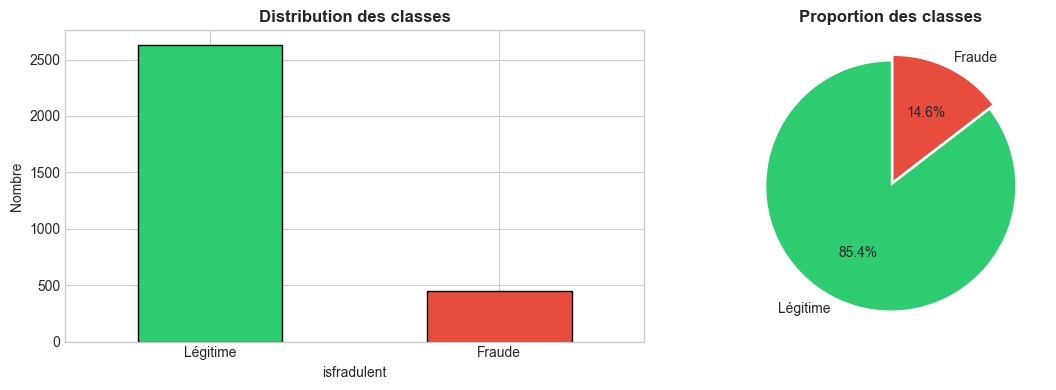

In [3]:
# Distribution des classes
fraud_counts = df['isfradulent'].value_counts()
fraud_pct = df['isfradulent'].value_counts(normalize=True) * 100

print("=" * 55)
print("       DISTRIBUTION DES CLASSES")
print("=" * 55)
print(f"  Légitimes (N) : {fraud_counts['N']:,}  ({fraud_pct['N']:.1f}%)")
print(f"  Fraudes   (Y) : {fraud_counts['Y']:,}    ({fraud_pct['Y']:.1f}%)")
print(f"  Ratio         : 1 fraude pour {fraud_counts['N']/fraud_counts['Y']:.1f} légitimes")
print("=" * 55)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
colors = ['#2ecc71', '#e74c3c']
fraud_counts.plot.bar(ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Distribution des classes', fontweight='bold')
axes[0].set_ylabel('Nombre')
axes[0].set_xticklabels(['Légitime', 'Fraude'], rotation=0)

axes[1].pie(fraud_counts, labels=['Légitime', 'Fraude'], autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0, 0.05])
axes[1].set_title('Proportion des classes', fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Nettoyage des Données

### ⚠️ Corrections importantes vs. l'ancienne version :
- Suppression des identifiants (`actionnr`, `merchant_id`) qui ne sont pas prédictifs
- Encodage binaire des variables catégorielles
- Détection des outliers par méthode IQR
- **Pas de feature engineering ici** — cela sera fait APRÈS le split train/test

In [4]:
df_clean = df.copy()

# 1. Encodage binaire Y/N → 1/0
binary_columns = ['is_declined', 'isforeigntransaction', 'ishighriskcountry', 'isfradulent']
for col in binary_columns:
    df_clean[col] = (df_clean[col] == 'Y').astype(int)

# 2. Suppression des identifiants
df_clean = df_clean.drop(['actionnr', 'merchant_id'], axis=1)

# 3. Vérification des doublons
duplicates = df_clean.duplicated().sum()
print(f"🔄 Doublons détectés : {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"   → Supprimés. Nouveau shape : {df_clean.shape}")

# 4. Détection des outliers (IQR)
print("\n📊 Détection des outliers (méthode IQR) :")
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_info = {}
for col in numeric_cols:
    if col != 'isfradulent':
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        n_outliers = ((df_clean[col] < Q1 - 1.5*IQR) | (df_clean[col] > Q3 + 1.5*IQR)).sum()
        if n_outliers > 0:
            outlier_info[col] = n_outliers
            print(f"   - {col}: {n_outliers} outliers ({n_outliers/len(df_clean)*100:.1f}%)")

print(f"\n✅ Dataset nettoyé : {df_clean.shape}")
print(f"\n📋 Statistiques descriptives :")
print(df_clean.describe().round(2).to_string())

🔄 Doublons détectés : 0

📊 Détection des outliers (méthode IQR) :
   - transaction_amount: 374 outliers (12.2%)
   - is_declined: 74 outliers (2.4%)
   - total_number_of_declines_day: 716 outliers (23.3%)
   - isforeigntransaction: 725 outliers (23.6%)
   - ishighriskcountry: 325 outliers (10.6%)
   - daily_chargeback_avg_amt: 259 outliers (8.4%)
   - sixmonth_avg_chbk_amt: 232 outliers (7.5%)
   - sixmonth_chbk_freq: 205 outliers (6.7%)

✅ Dataset nettoyé : (3075, 10)

📋 Statistiques descriptives :
       average_amount_transaction_day  transaction_amount  is_declined  total_number_of_declines_day  isforeigntransaction  ishighriskcountry  daily_chargeback_avg_amt  sixmonth_avg_chbk_amt  sixmonth_chbk_freq  isfradulent
count                         3075.00             3075.00      3075.00                       3075.00               3075.00            3075.00                   3075.00                3075.00             3075.00      3075.00
mean                           234.43          

## 3. Analyse Exploratoire des Données (EDA)

In [5]:
# Séparation pour l'analyse
fraud_data = df_clean[df_clean['isfradulent'] == 1]
legit_data = df_clean[df_clean['isfradulent'] == 0]

print("=" * 60)
print("     PROFIL COMPARATIF : FRAUDE vs LÉGITIME")
print("=" * 60)
print(f"\n{'Métrique':<35} {'Légitime':>12} {'Fraude':>12}")
print("-" * 60)
print(f"{'Montant moyen ($)':<35} {legit_data['transaction_amount'].mean():>12,.2f} {fraud_data['transaction_amount'].mean():>12,.2f}")
print(f"{'Montant médian ($)':<35} {legit_data['transaction_amount'].median():>12,.2f} {fraud_data['transaction_amount'].median():>12,.2f}")
print(f"{'% transactions étrangères':<35} {legit_data['isforeigntransaction'].mean()*100:>11.1f}% {fraud_data['isforeigntransaction'].mean()*100:>11.1f}%")
print(f"{'% pays à haut risque':<35} {legit_data['ishighriskcountry'].mean()*100:>11.1f}% {fraud_data['ishighriskcountry'].mean()*100:>11.1f}%")
print(f"{'% transactions refusées':<35} {legit_data['is_declined'].mean()*100:>11.1f}% {fraud_data['is_declined'].mean()*100:>11.1f}%")
print(f"{'Nb moyen refus/jour':<35} {legit_data['total_number_of_declines_day'].mean():>12.2f} {fraud_data['total_number_of_declines_day'].mean():>12.2f}")
print(f"{'Chargeback moyen 6 mois ($)':<35} {legit_data['sixmonth_avg_chbk_amt'].mean():>12.2f} {fraud_data['sixmonth_avg_chbk_amt'].mean():>12.2f}")

     PROFIL COMPARATIF : FRAUDE vs LÉGITIME

Métrique                                Légitime       Fraude
------------------------------------------------------------
Montant moyen ($)                       3,602.02    42,706.37
Montant médian ($)                      1,718.42    15,523.42
% transactions étrangères                  15.0%        74.1%
% pays à haut risque                        5.1%        42.4%
% transactions refusées                     1.5%         7.8%
Nb moyen refus/jour                         0.22         1.40
Chargeback moyen 6 mois ($)                 8.35        30.01


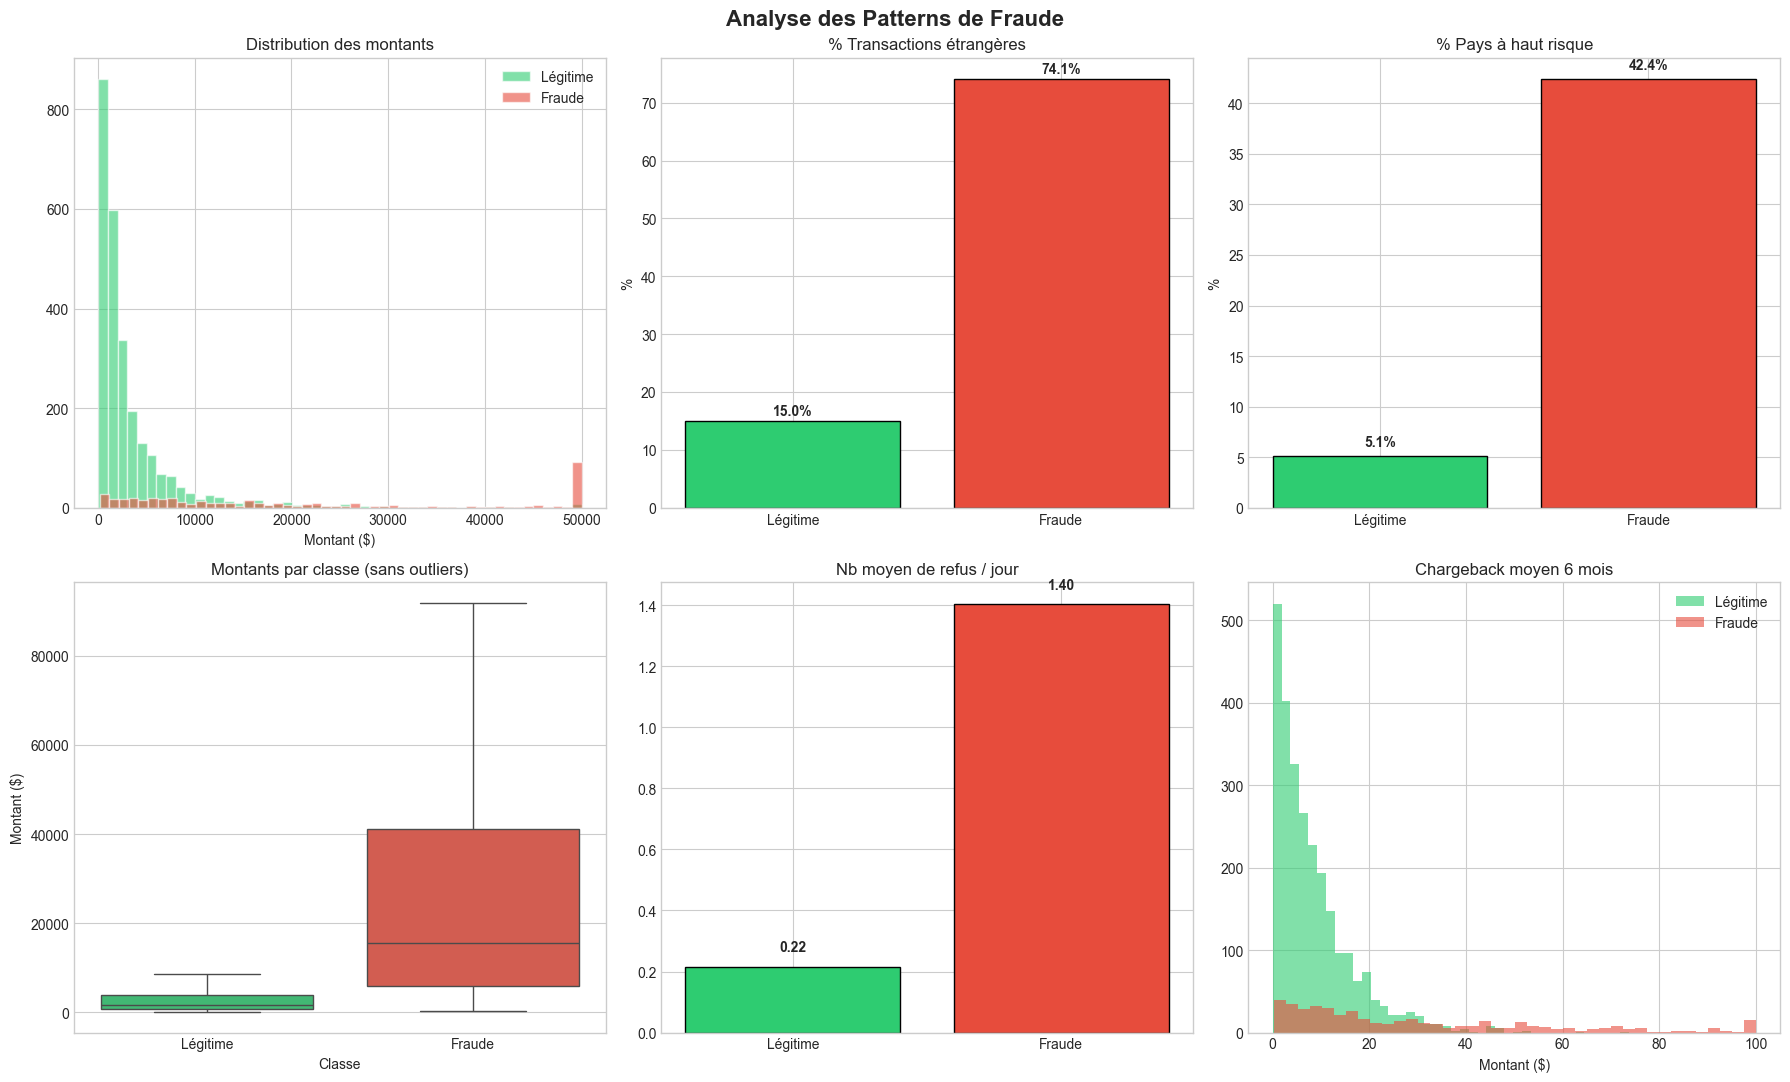

In [6]:
# Visualisations EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 11))
fig.suptitle('Analyse des Patterns de Fraude', fontsize=16, fontweight='bold')

# 1. Distribution des montants
axes[0,0].hist(legit_data['transaction_amount'].clip(upper=50000), bins=50, alpha=0.6, 
               label='Légitime', color='#2ecc71', edgecolor='white')
axes[0,0].hist(fraud_data['transaction_amount'].clip(upper=50000), bins=50, alpha=0.6, 
               label='Fraude', color='#e74c3c', edgecolor='white')
axes[0,0].set_xlabel('Montant ($)')
axes[0,0].set_title('Distribution des montants')
axes[0,0].legend()

# 2. Transactions étrangères
foreign_rates = [legit_data['isforeigntransaction'].mean()*100, fraud_data['isforeigntransaction'].mean()*100]
axes[0,1].bar(['Légitime', 'Fraude'], foreign_rates, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0,1].set_title('% Transactions étrangères')
axes[0,1].set_ylabel('%')
for i, v in enumerate(foreign_rates):
    axes[0,1].text(i, v+1, f'{v:.1f}%', ha='center', fontweight='bold')

# 3. Pays à haut risque
risk_rates = [legit_data['ishighriskcountry'].mean()*100, fraud_data['ishighriskcountry'].mean()*100]
axes[0,2].bar(['Légitime', 'Fraude'], risk_rates, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[0,2].set_title('% Pays à haut risque')
axes[0,2].set_ylabel('%')
for i, v in enumerate(risk_rates):
    axes[0,2].text(i, v+1, f'{v:.1f}%', ha='center', fontweight='bold')

# 4. Box plot des montants
plot_df = df_clean[['transaction_amount', 'isfradulent']].copy()
plot_df['Classe'] = plot_df['isfradulent'].map({0: 'Légitime', 1: 'Fraude'})
sns.boxplot(data=plot_df, x='Classe', y='transaction_amount', ax=axes[1,0], 
            palette=['#2ecc71', '#e74c3c'], showfliers=False)
axes[1,0].set_title('Montants par classe (sans outliers)')
axes[1,0].set_ylabel('Montant ($)')

# 5. Nombre de refus par jour
decline_rates = [legit_data['total_number_of_declines_day'].mean(), fraud_data['total_number_of_declines_day'].mean()]
axes[1,1].bar(['Légitime', 'Fraude'], decline_rates, color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1,1].set_title('Nb moyen de refus / jour')
for i, v in enumerate(decline_rates):
    axes[1,1].text(i, v+0.05, f'{v:.2f}', ha='center', fontweight='bold')

# 6. Chargeback 6 mois
axes[1,2].hist(legit_data['sixmonth_avg_chbk_amt'].clip(upper=100), bins=40, alpha=0.6, 
               label='Légitime', color='#2ecc71')
axes[1,2].hist(fraud_data['sixmonth_avg_chbk_amt'].clip(upper=100), bins=40, alpha=0.6, 
               label='Fraude', color='#e74c3c')
axes[1,2].set_xlabel('Montant ($)')
axes[1,2].set_title('Chargeback moyen 6 mois')
axes[1,2].legend()

plt.tight_layout()
plt.show()

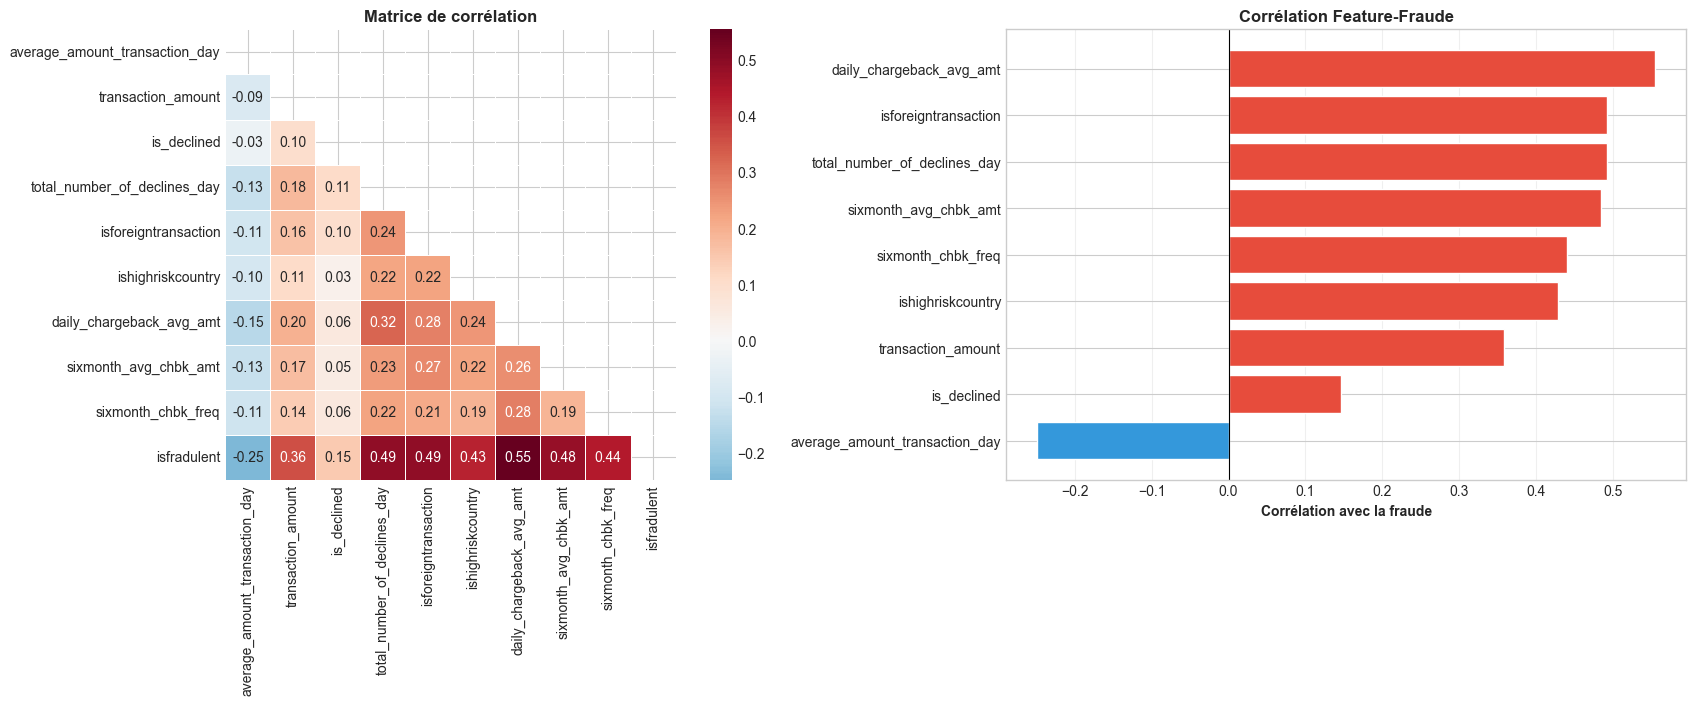


Top features corrélées avec la fraude :
  daily_chargeback_avg_amt            : +0.5547
  isforeigntransaction                : +0.4916
  total_number_of_declines_day        : +0.4915
  sixmonth_avg_chbk_amt               : +0.4848
  sixmonth_chbk_freq                  : +0.4398
  ishighriskcountry                   : +0.4277
  transaction_amount                  : +0.3585
  average_amount_transaction_day      : -0.2490
  is_declined                         : +0.1457


In [7]:
# Matrice de corrélation
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Heatmap
corr = df_clean.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=axes[0], square=True, linewidths=0.5)
axes[0].set_title('Matrice de corrélation', fontweight='bold', fontsize=12)

# Corrélation avec la cible
fraud_corr = df_clean.drop('isfradulent', axis=1).corrwith(df_clean['isfradulent']).sort_values()
colors = ['#e74c3c' if x > 0 else '#3498db' for x in fraud_corr.values]
axes[1].barh(fraud_corr.index, fraud_corr.values, color=colors, edgecolor='white')
axes[1].set_xlabel('Corrélation avec la fraude', fontweight='bold')
axes[1].set_title('Corrélation Feature-Fraude', fontweight='bold', fontsize=12)
axes[1].axvline(x=0, color='black', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop features corrélées avec la fraude :")
for feat, val in fraud_corr.abs().sort_values(ascending=False).items():
    print(f"  {feat:<35} : {fraud_corr[feat]:+.4f}")

## 4. Séparation Train/Test AVANT Feature Engineering

### 🚨 Correction critique : Data Leakage
Dans l'ancienne version, le feature engineering était fait **avant** le split, ce qui cause une fuite d'information :
- Les statistiques globales (quantiles, moyennes) utilisées pour créer des features incluaient les données de test
- Résultat : les performances étaient artificiellement gonflées

**Solution** : On sépare d'abord, puis on applique le feature engineering uniquement sur le train.

In [8]:
# Séparation des features et de la cible
X = df_clean.drop('isfradulent', axis=1)
y = df_clean['isfradulent']

# Split stratifié 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 55)
print("       SÉPARATION DES DONNÉES")
print("=" * 55)
print(f"  Train : {X_train.shape[0]:,} transactions ({y_train.sum():,} fraudes = {y_train.mean()*100:.1f}%)")
print(f"  Test  : {X_test.shape[0]:,} transactions  ({y_test.sum():,} fraudes = {y_test.mean()*100:.1f}%)")
print("=" * 55)

       SÉPARATION DES DONNÉES
  Train : 2,460 transactions (358 fraudes = 14.6%)
  Test  : 615 transactions  (90 fraudes = 14.6%)


## 5. Feature Engineering (APRÈS le split)

### Approche corrigée :
- Les features sont créées **séparément** sur train et test
- Pas de features qui encodent trop directement la cible (pas de `risk_score` composite)
- Features basées uniquement sur des **relations entre variables**

In [9]:
def engineer_features(df):
    """Crée de nouvelles features à partir des données existantes.
    Cette fonction est appliquée séparément sur train et test pour éviter le data leakage.
    """
    X = df.copy()
    
    # 1. Ratio montant / moyenne journalière (le plus discriminant naturellement)
    X['amount_ratio'] = X['transaction_amount'] / (X['average_amount_transaction_day'] + 1)
    
    # 2. Log du montant (réduit l'impact des outliers)
    X['log_amount'] = np.log1p(X['transaction_amount'])
    
    # 3. Interaction : transaction étrangère ET pays à risque
    X['foreign_and_risky'] = X['isforeigntransaction'] * X['ishighriskcountry']
    
    # 4. Taux de refus normalisé
    X['decline_rate'] = X['total_number_of_declines_day'] / (X['total_number_of_declines_day'] + 1)
    
    # 5. Ratio chargeback court terme / long terme
    X['chargeback_ratio'] = X['daily_chargeback_avg_amt'] / (X['sixmonth_avg_chbk_amt'] + 1)
    
    # 6. Interaction montant × étranger
    X['amount_x_foreign'] = X['transaction_amount'] * X['isforeigntransaction']
    
    # Nettoyage des infinis
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(0, inplace=True)
    
    return X

# Appliquer SÉPARÉMENT sur train et test
X_train_eng = engineer_features(X_train)
X_test_eng = engineer_features(X_test)

print(f"✅ Features originales : {X_train.shape[1]}")
print(f"✅ Features après engineering : {X_train_eng.shape[1]}")
print(f"\nNouvelles features créées :")
new_features = [c for c in X_train_eng.columns if c not in X_train.columns]
for f in new_features:
    print(f"  → {f}")

print(f"\n📊 Aperçu des nouvelles features (train) :")
print(X_train_eng[new_features].describe().round(2).to_string())

✅ Features originales : 9
✅ Features après engineering : 15

Nouvelles features créées :
  → amount_ratio
  → log_amount
  → foreign_and_risky
  → decline_rate
  → chargeback_ratio
  → amount_x_foreign

📊 Aperçu des nouvelles features (train) :
       amount_ratio  log_amount  foreign_and_risky  decline_rate  chargeback_ratio  amount_x_foreign
count       2460.00     2460.00            2460.00       2460.00           2460.00           2460.00
mean          99.33        7.77               0.05          0.14              1.47           4710.68
std          496.29        1.47               0.22          0.25              3.54          32014.38
min            0.06        3.24               0.00          0.00              0.00              0.00
25%            3.76        6.76               0.00          0.00              0.19              0.00
50%           11.66        7.65               0.00          0.00              0.53              0.00
75%           41.21        8.68               0.

In [10]:
# Standardisation
scaler = RobustScaler()  # Plus robuste aux outliers que StandardScaler
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Versions pour les modèles basés sur les arbres (pas besoin de scaling)
X_train_tree = X_train_eng.values
X_test_tree = X_test_eng.values

feature_names = X_train_eng.columns.tolist()
print(f"✅ Données standardisées (RobustScaler)")
print(f"   Shape train: {X_train_scaled.shape}")
print(f"   Shape test:  {X_test_scaled.shape}")

✅ Données standardisées (RobustScaler)
   Shape train: (2460, 15)
   Shape test:  (615, 15)


## 6. Gestion du Déséquilibre des Classes

### Stratégie : Sous-échantillonnage aléatoire du train
- On réduit la classe majoritaire pour équilibrer les classes
- Combiné avec `class_weight='balanced'` dans les modèles
- Le test reste intact pour une évaluation réaliste

In [11]:
# Sous-échantillonnage pour créer un dataset équilibré
from sklearn.utils import resample

train_df = pd.DataFrame(X_train_eng)
train_df['target'] = y_train.values

# Séparer les classes
majority = train_df[train_df['target'] == 0]
minority = train_df[train_df['target'] == 1]

# Sous-échantillonner la classe majoritaire
majority_downsampled = resample(majority, 
                                replace=False, 
                                n_samples=len(minority) * 2,  # ratio 2:1
                                random_state=42)

# Combiner
train_balanced = pd.concat([majority_downsampled, minority])
train_balanced = train_balanced.sample(frac=1, random_state=42)

X_train_bal = train_balanced.drop('target', axis=1).values
y_train_bal = train_balanced['target'].values

# Aussi en version scaled
X_train_bal_scaled = scaler.transform(train_balanced.drop('target', axis=1))

print("=" * 55)
print("       SOUS-ÉCHANTILLONNAGE")
print("=" * 55)
print(f"  Avant  : {len(y_train)} samples ({y_train.sum()} fraudes = {y_train.mean()*100:.1f}%)")
print(f"  Après  : {len(y_train_bal)} samples ({y_train_bal.sum()} fraudes = {y_train_bal.mean()*100:.1f}%)")
print(f"  Ratio  : {(y_train_bal == 0).sum()}:{(y_train_bal == 1).sum()} (Légitimes:Fraudes)")
print("=" * 55)

       SOUS-ÉCHANTILLONNAGE
  Avant  : 2460 samples (358 fraudes = 14.6%)
  Après  : 1074 samples (358 fraudes = 33.3%)
  Ratio  : 716:358 (Légitimes:Fraudes)


## 7. Entraînement et Évaluation des Modèles

### 8 modèles comparés :
1. Régression Logistique (baseline)
2. K-Nearest Neighbors (KNN)
3. Naive Bayes
4. Arbre de Décision
5. Random Forest
6. Gradient Boosting
7. AdaBoost
8. Bagging Classifier

In [12]:
# Définition des modèles
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced', C=0.1),
        'needs_scaling': True
    },
    'KNN (k=5)': {
        'model': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'needs_scaling': True
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'needs_scaling': True
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, 
                                        random_state=42, class_weight='balanced'),
        'needs_scaling': False
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5,
                                       random_state=42, class_weight='balanced', n_jobs=-1),
        'needs_scaling': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, 
                                           max_depth=4, min_samples_leaf=10,
                                           subsample=0.8, random_state=42),
        'needs_scaling': False
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        'needs_scaling': False
    },
    'Bagging': {
        'model': BaggingClassifier(n_estimators=100, max_samples=0.8, 
                                   random_state=42, n_jobs=-1),
        'needs_scaling': False
    }
}

print(f"✅ {len(models)} modèles définis")
for name in models:
    print(f"   → {name}")

✅ 8 modèles définis
   → Logistic Regression
   → KNN (k=5)
   → Naive Bayes
   → Decision Tree
   → Random Forest
   → Gradient Boosting
   → AdaBoost
   → Bagging


## 8. Validation Croisée Stratifiée (5-Fold)

### Pourquoi la validation croisée ?
- Une seule évaluation sur un split peut être trompeuse avec un petit dataset (3075 samples)
- La CV donne des **intervalles de confiance** sur les métriques
- On détecte l'**overfitting** si le score train >> score test

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("=" * 75)
print(f"{'Modèle':<22} {'Accuracy':>10} {'F1 (Fraud)':>12} {'ROC-AUC':>12} {'Recall':>10}")
print("=" * 75)

for name, config in models.items():
    model = config['model']
    
    if config['needs_scaling']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train_tree
    
    # Cross-validation multi-métriques
    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'recall': 'recall',
        'precision': 'precision'
    }
    
    scores = cross_validate(model, X_cv, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    cv_results[name] = {
        'accuracy_mean': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'f1_mean': scores['test_f1'].mean(),
        'f1_std': scores['test_f1'].std(),
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'recall_mean': scores['test_recall'].mean(),
        'recall_std': scores['test_recall'].std(),
        'precision_mean': scores['test_precision'].mean(),
        'precision_std': scores['test_precision'].std(),
        'train_accuracy': scores['train_accuracy'].mean(),
        'train_f1': scores['train_f1'].mean(),
    }
    
    r = cv_results[name]
    print(f"{name:<22} {r['accuracy_mean']:.4f}±{r['accuracy_std']:.3f} "
          f"{r['f1_mean']:.4f}±{r['f1_std']:.3f} "
          f"{r['roc_auc_mean']:.4f}±{r['roc_auc_std']:.3f} "
          f"{r['recall_mean']:.4f}±{r['recall_std']:.3f}")

print("=" * 75)

Modèle                   Accuracy   F1 (Fraud)      ROC-AUC     Recall
Logistic Regression    0.9630±0.005 0.8822±0.015 0.9943±0.001 0.9498±0.027
KNN (k=5)              0.9122±0.016 0.6691±0.068 0.9168±0.017 0.6143±0.074
Naive Bayes            0.9350±0.009 0.7488±0.037 0.9761±0.004 0.6677±0.045
Decision Tree          0.9228±0.009 0.7706±0.019 0.9381±0.013 0.8882±0.029
Random Forest          0.9634±0.008 0.8777±0.026 0.9917±0.002 0.9022±0.034
Gradient Boosting      0.9760±0.005 0.9155±0.015 0.9929±0.002 0.8910±0.021
AdaBoost               0.9646±0.005 0.8649±0.020 0.9926±0.002 0.7795±0.031
Bagging                0.9695±0.006 0.8922±0.023 0.9850±0.004 0.8686±0.037


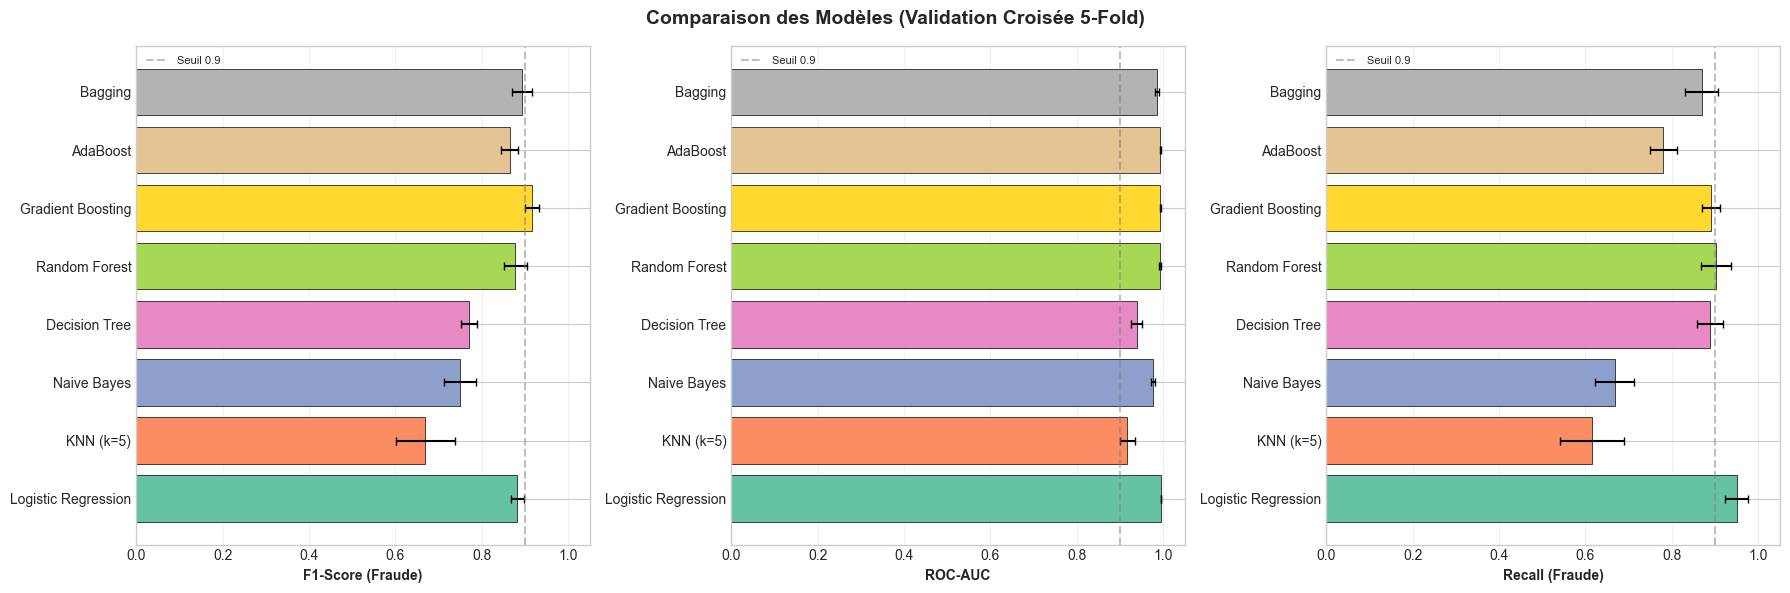

In [14]:
# Visualisation des résultats CV
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparaison des Modèles (Validation Croisée 5-Fold)', fontsize=14, fontweight='bold')

model_names = list(cv_results.keys())
metrics = {
    'F1-Score (Fraude)': ('f1_mean', 'f1_std'),
    'ROC-AUC': ('roc_auc_mean', 'roc_auc_std'),
    'Recall (Fraude)': ('recall_mean', 'recall_std')
}

colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

for idx, (metric_name, (mean_key, std_key)) in enumerate(metrics.items()):
    means = [cv_results[m][mean_key] for m in model_names]
    stds = [cv_results[m][std_key] for m in model_names]
    
    bars = axes[idx].barh(model_names, means, xerr=stds, color=colors, 
                          edgecolor='black', linewidth=0.5, capsize=3)
    axes[idx].set_xlabel(metric_name, fontweight='bold')
    axes[idx].set_xlim(0, 1.05)
    axes[idx].axvline(x=0.9, color='gray', linestyle='--', alpha=0.5, label='Seuil 0.9')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Détection de l'overfitting : Train vs Test
print("=" * 65)
print("       DIAGNOSTIC D'OVERFITTING (Train vs CV-Test)")
print("=" * 65)
print(f"{'Modèle':<22} {'Train Acc':>10} {'CV Acc':>10} {'Écart':>8} {'Status':>12}")
print("-" * 65)

for name, r in cv_results.items():
    gap = r['train_accuracy'] - r['accuracy_mean']
    status = "⚠️ Overfit" if gap > 0.05 else "✅ OK"
    print(f"{name:<22} {r['train_accuracy']:.4f}     {r['accuracy_mean']:.4f}     {gap:+.4f}   {status}")
print("-" * 65)

       DIAGNOSTIC D'OVERFITTING (Train vs CV-Test)
Modèle                  Train Acc     CV Acc    Écart       Status
-----------------------------------------------------------------
Logistic Regression    0.9651     0.9630     +0.0021   ✅ OK
KNN (k=5)              1.0000     0.9122     +0.0878   ⚠️ Overfit
Naive Bayes            0.9350     0.9350     +0.0000   ✅ OK
Decision Tree          0.9524     0.9228     +0.0297   ✅ OK
Random Forest          0.9812     0.9634     +0.0178   ✅ OK
Gradient Boosting      0.9975     0.9760     +0.0214   ✅ OK
AdaBoost               0.9691     0.9646     +0.0045   ✅ OK
Bagging                0.9992     0.9695     +0.0297   ✅ OK
-----------------------------------------------------------------


## 9. Évaluation Finale sur le Jeu de Test

### Les modèles sont entraînés sur tout le train et évalués sur le test (données jamais vues)

In [ ]:
# Entraîner et évaluer chaque modèle sur le jeu de test
test_results = {}
trained_models = {}
predictions = {}
probabilities = {}

for name, config in models.items():
    model = config['model']
    
    if config['needs_scaling']:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        try:
            probs = model.predict_proba(X_test_scaled)[:, 1]
        except:
            probs = model.decision_function(X_test_scaled)
    else:
        model.fit(X_train_tree, y_train)
        preds = model.predict(X_test_tree)
        probs = model.predict_proba(X_test_tree)[:, 1]
    
    trained_models[name] = model
    predictions[name] = preds
    probabilities[name] = probs
    
    test_results[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_test, probs),
        'mcc': matthews_corrcoef(y_test, preds),
        'avg_precision': average_precision_score(y_test, probs)
    }

# Tableau des résultats
results_df = pd.DataFrame(test_results).T
results_df = results_df.sort_values('f1', ascending=False)

print("=" * 95)
print("                    RÉSULTATS SUR LE JEU DE TEST")
print("=" * 95)
print(results_df.round(4).to_string())
print("=" * 95)

print(f"\n Meilleur modèle (F1) : {results_df.index[0]} (F1={results_df.iloc[0]['f1']:.4f})")

                    RÉSULTATS SUR LE JEU DE TEST
                     accuracy  precision  recall      f1  roc_auc     mcc  avg_precision
Logistic Regression    0.9756     0.9121  0.9222  0.9171   0.9873  0.9028         0.9615
Gradient Boosting      0.9772     0.9872  0.8556  0.9167   0.9832  0.9067         0.9660
Random Forest          0.9756     0.9213  0.9111  0.9162   0.9821  0.9019         0.9604
Bagging                0.9756     0.9630  0.8667  0.9123   0.9741  0.8998         0.9476
AdaBoost               0.9593     0.9851  0.7333  0.8408   0.9831  0.8297         0.9536
Decision Tree          0.9398     0.7573  0.8667  0.8083   0.9324  0.7753         0.8369
Naive Bayes            0.9301     0.8310  0.6556  0.7329   0.9694  0.6998         0.8434
KNN (k=5)              0.9154     0.7375  0.6556  0.6941   0.9041  0.6468         0.7415

🏆 Meilleur modèle (F1) : Logistic Regression (F1=0.9171)


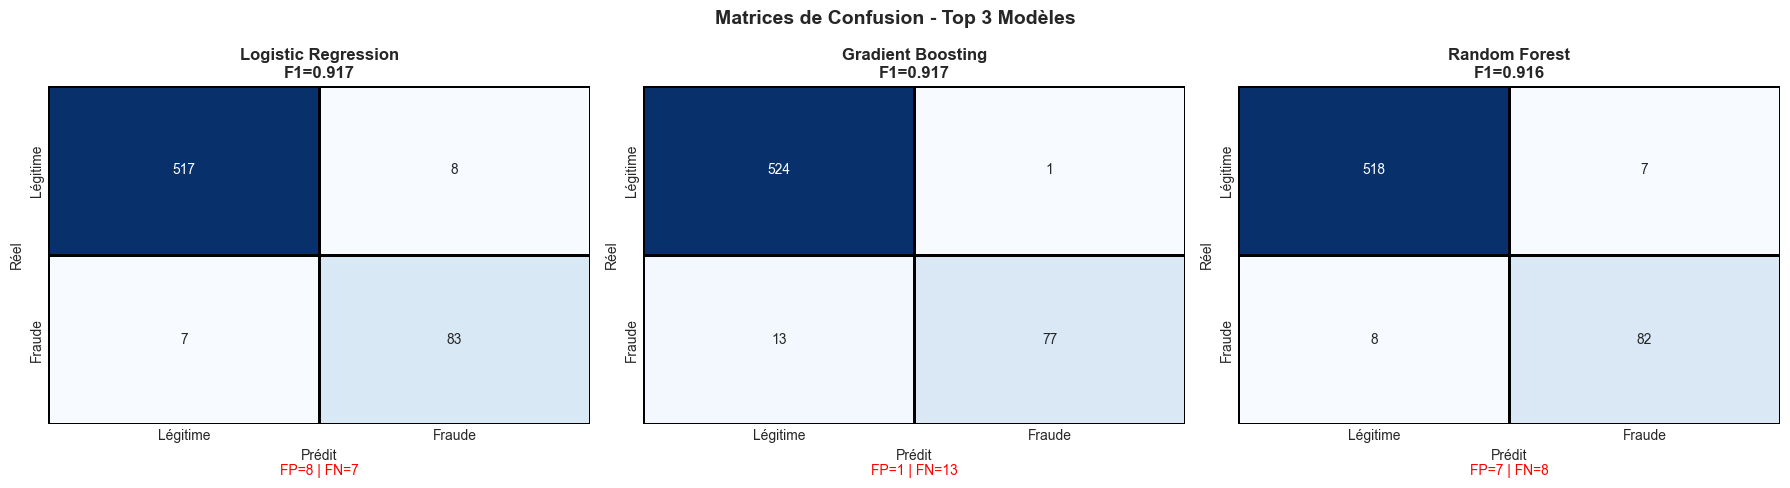


📋 Rapport de classification détaillé : Logistic Regression
              precision    recall  f1-score   support

    Légitime     0.9866    0.9848    0.9857       525
      Fraude     0.9121    0.9222    0.9171        90

    accuracy                         0.9756       615
   macro avg     0.9494    0.9535    0.9514       615
weighted avg     0.9757    0.9756    0.9757       615



In [17]:
# Matrices de confusion des 3 meilleurs modèles
top_3 = results_df.head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusion - Top 3 Modèles', fontsize=14, fontweight='bold')

for idx, name in enumerate(top_3):
    cm = confusion_matrix(y_test, predictions[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Légitime', 'Fraude'], yticklabels=['Légitime', 'Fraude'],
                cbar=False, linewidths=1, linecolor='black')
    axes[idx].set_title(f'{name}\nF1={test_results[name]["f1"]:.3f}', fontweight='bold')
    axes[idx].set_ylabel('Réel')
    axes[idx].set_xlabel('Prédit')
    
    tn, fp, fn, tp = cm.ravel()
    axes[idx].text(0.5, -0.15, f'FP={fp} | FN={fn}', transform=axes[idx].transAxes,
                   ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Rapport de classification détaillé du meilleur
best_name = top_3[0]
print(f"\n📋 Rapport de classification détaillé : {best_name}")
print(classification_report(y_test, predictions[best_name], 
                          target_names=['Légitime', 'Fraude'], digits=4))

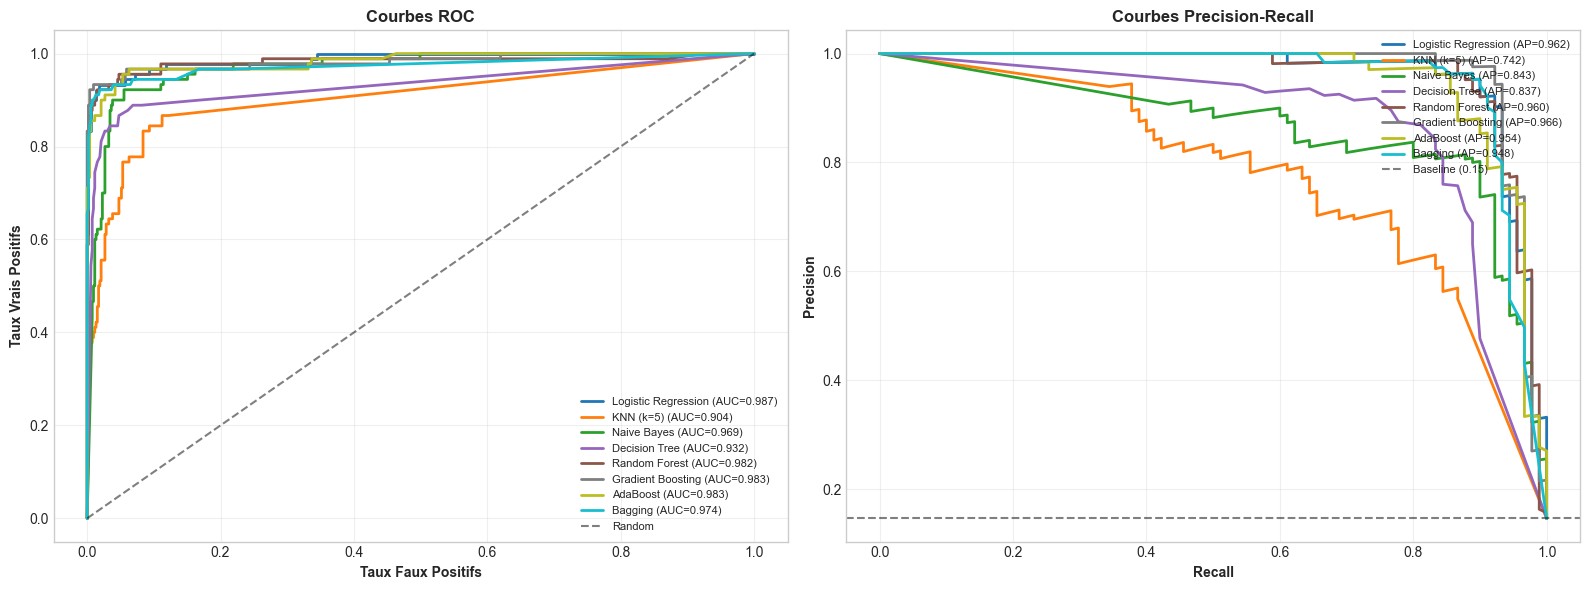

In [18]:
# Courbes ROC et Precision-Recall
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

# Courbe ROC
for idx, (name, probs_arr) in enumerate(probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test, probs_arr)
    auc = roc_auc_score(y_test, probs_arr)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2, color=colors[idx])

axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0].set_xlabel('Taux Faux Positifs', fontweight='bold')
axes[0].set_ylabel('Taux Vrais Positifs', fontweight='bold')
axes[0].set_title('Courbes ROC', fontweight='bold', fontsize=12)
axes[0].legend(loc='lower right', fontsize=8)
axes[0].grid(alpha=0.3)

# Courbe Precision-Recall
for idx, (name, probs_arr) in enumerate(probabilities.items()):
    prec, rec, _ = precision_recall_curve(y_test, probs_arr)
    ap = average_precision_score(y_test, probs_arr)
    axes[1].plot(rec, prec, label=f'{name} (AP={ap:.3f})', linewidth=2, color=colors[idx])

axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label=f'Baseline ({y_test.mean():.2f})')
axes[1].set_xlabel('Recall', fontweight='bold')
axes[1].set_ylabel('Precision', fontweight='bold')
axes[1].set_title('Courbes Precision-Recall', fontweight='bold', fontsize=12)
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Optimisation des Hyperparamètres

### RandomizedSearchCV sur le meilleur modèle
Plus efficace que GridSearchCV pour les grands espaces de recherche.

In [19]:
# Tuning du Random Forest
print(" Optimisation des hyperparamètres - Random Forest...")
print("   (RandomizedSearchCV, 5-Fold, 50 itérations)\n")

param_distributions = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_search.fit(X_train_tree, y_train)

print(f" Meilleurs hyperparamètres :")
for param, value in rf_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n Score CV (F1) : {rf_search.best_score_:.4f}")

# Évaluation du modèle optimisé
best_rf = rf_search.best_estimator_
best_rf_preds = best_rf.predict(X_test_tree)
best_rf_probs = best_rf.predict_proba(X_test_tree)[:, 1]

print(f"\n Performance sur le test (RF optimisé) :")
print(f"   Accuracy  : {accuracy_score(y_test, best_rf_preds):.4f}")
print(f"   Precision : {precision_score(y_test, best_rf_preds):.4f}")
print(f"   Recall    : {recall_score(y_test, best_rf_preds):.4f}")
print(f"   F1-Score  : {f1_score(y_test, best_rf_preds):.4f}")
print(f"   ROC-AUC   : {roc_auc_score(y_test, best_rf_probs):.4f}")
print(f"   MCC       : {matthews_corrcoef(y_test, best_rf_preds):.4f}")

# Comparaison avant/après tuning
print(f"\n Comparaison avant/après tuning :")
print(f"   F1 avant : {test_results['Random Forest']['f1']:.4f}")
print(f"   F1 après : {f1_score(y_test, best_rf_preds):.4f}")
print(f"   Gain     : {f1_score(y_test, best_rf_preds) - test_results['Random Forest']['f1']:+.4f}")

🔧 Optimisation des hyperparamètres - Random Forest...
   (RandomizedSearchCV, 5-Fold, 50 itérations)

✅ Meilleurs hyperparamètres :
   n_estimators: 100
   min_samples_split: 5
   min_samples_leaf: 2
   max_features: log2
   max_depth: 10
   class_weight: balanced

📊 Score CV (F1) : 0.9002

📋 Performance sur le test (RF optimisé) :
   Accuracy  : 0.9837
   Precision : 0.9762
   Recall    : 0.9111
   F1-Score  : 0.9425
   ROC-AUC   : 0.9861
   MCC       : 0.9338

🔄 Comparaison avant/après tuning :
   F1 avant : 0.9162
   F1 après : 0.9425
   Gain     : +0.0263


## 11. Courbes d'Apprentissage

### Diagnostic biais/variance
- Si les courbes train et test convergent vers un score élevé → bon modèle
- Si train >> test → overfitting 
- Si les deux scores sont bas → underfitting

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Courbes d'Apprentissage", fontsize=14, fontweight='bold')

models_to_plot = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=42, class_weight='balanced'),
    'Random Forest': best_rf,
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=4, random_state=42)
}

for idx, (name, model) in enumerate(models_to_plot.items()):
    row, col = idx // 2, idx % 2
    ax = axes[row, col]
    
    needs_scaling = name in ['Logistic Regression']
    X_lc = X_train_scaled if needs_scaling else X_train_tree
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_lc, y_train, cv=5, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42
    )
    
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)
    
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Train', linewidth=2)
    ax.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation', linewidth=2)
    
    gap = train_mean[-1] - test_mean[-1]
    status = "⚠️ Overfit" if gap > 0.05 else "✅ OK"
    ax.set_title(f'{name} (gap={gap:.3f}) {status}', fontweight='bold')
    ax.set_xlabel('Taille du train')
    ax.set_ylabel('F1-Score')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 12. Importance des Features

In [ ]:
# Feature importance du meilleur Random Forest
importances = best_rf.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(feat_imp)))
axes[0].barh(feat_imp['Feature'], feat_imp['Importance'], color=colors, edgecolor='white')
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title('Feature Importance (Random Forest optimisé)', fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Cumulative importance
feat_imp_sorted = feat_imp.sort_values('Importance', ascending=False)
cumulative = feat_imp_sorted['Importance'].cumsum()
axes[1].plot(range(1, len(cumulative)+1), cumulative.values, 'bo-', linewidth=2)
axes[1].axhline(y=0.9, color='red', linestyle='--', label='90% importance')
n_90 = (cumulative < 0.9).sum() + 1
axes[1].axvline(x=n_90, color='green', linestyle='--', label=f'{n_90} features suffisent')
axes[1].set_xlabel('Nombre de features', fontweight='bold')
axes[1].set_ylabel('Importance cumulée', fontweight='bold')
axes[1].set_title('Importance cumulée des features', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Top features :")
for _, row in feat_imp.head(8).iterrows():
    bar = '█' * int(row['Importance'] * 50)
    print(f"  {row['Feature']:<35} {row['Importance']:.4f} {bar}")

## 13. Visualisation PCA

In [ ]:
# PCA 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

fig, ax = plt.subplots(figsize=(10, 7))

scatter_legit = ax.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], 
                           c='#2ecc71', alpha=0.4, s=20, label='Légitime', edgecolor='none')
scatter_fraud = ax.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], 
                           c='#e74c3c', alpha=0.8, s=60, label='Fraude', edgecolor='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontweight='bold')
ax.set_title('Projection PCA - Fraude vs Légitime', fontweight='bold', fontsize=14)
ax.legend(fontsize=12)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nVariance expliquée par PC1 : {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance expliquée par PC2 : {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total (2 composantes)      : {sum(pca.explained_variance_ratio_)*100:.2f}%")

## 14. Analyse des Seuils de Décision

In [ ]:
best_model_name = results_df.index[0]
best_probs = probabilities[best_model_name]

thresholds = np.arange(0.1, 0.95, 0.05)
threshold_data = []

for t in thresholds:
    preds_t = (best_probs >= t).astype(int)
    if preds_t.sum() > 0:
        threshold_data.append({
            'Threshold': t,
            'Precision': precision_score(y_test, preds_t, zero_division=0),
            'Recall': recall_score(y_test, preds_t, zero_division=0),
            'F1': f1_score(y_test, preds_t, zero_division=0),
            'FP': ((preds_t == 1) & (y_test == 0)).sum(),
            'FN': ((preds_t == 0) & (y_test == 1)).sum()
        })

thresh_df = pd.DataFrame(threshold_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall vs Threshold
axes[0].plot(thresh_df['Threshold'], thresh_df['Precision'], 'b-o', label='Precision', linewidth=2)
axes[0].plot(thresh_df['Threshold'], thresh_df['Recall'], 'r-o', label='Recall', linewidth=2)
axes[0].plot(thresh_df['Threshold'], thresh_df['F1'], 'g-o', label='F1-Score', linewidth=2)

best_thresh_idx = thresh_df['F1'].idxmax()
best_thresh = thresh_df.loc[best_thresh_idx, 'Threshold']
axes[0].axvline(x=best_thresh, color='gray', linestyle='--', label=f'Optimal: {best_thresh:.2f}')
axes[0].set_xlabel('Seuil de décision', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Métriques vs Seuil de décision', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# FP/FN vs Threshold
axes[1].plot(thresh_df['Threshold'], thresh_df['FP'], 'b-o', label='Faux Positifs', linewidth=2)
axes[1].plot(thresh_df['Threshold'], thresh_df['FN'], 'r-o', label='Faux Négatifs', linewidth=2)
axes[1].axvline(x=best_thresh, color='gray', linestyle='--', label=f'Optimal: {best_thresh:.2f}')
axes[1].set_xlabel('Seuil de décision', fontweight='bold')
axes[1].set_ylabel('Nombre', fontweight='bold')
axes[1].set_title('Erreurs vs Seuil de décision', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Seuil optimal (max F1) : {best_thresh:.2f}")
print(thresh_df.round(3).to_string(index=False))

## 15. Analyse d'Impact Business

In [ ]:
fraud_loss = 500
fp_cost = 50
churn_cost = 200

print("=" * 60)
print("       ANALYSE D'IMPACT FINANCIER")
print("=" * 60)

for name in results_df.head(3).index:
    cm = confusion_matrix(y_test, predictions[name])
    tn, fp, fn, tp = cm.ravel()
    
    fraud_prevented = tp * fraud_loss
    fraud_missed = fn * fraud_loss
    fp_total_cost = fp * (fp_cost + churn_cost)
    net_benefit = fraud_prevented - fraud_missed - fp_total_cost
    
    print(f"\n {name} :")
    print(f"   Fraudes prévenues  : {tp} cas = {fraud_prevented:>10,}$")
    print(f"   Fraudes manquées   : {fn} cas = {fraud_missed:>10,}$")
    print(f"   Faux positifs      : {fp} cas = {fp_total_cost:>10,}$")
    print(f"   ─────────────────────────────────────")
    print(f"   BÉNÉFICE NET       :          {net_benefit:>10,}$")
    
print("\n" + "=" * 60)

## 16. Conclusion et Recommandations

### 📊 Résumé des améliorations méthodologiques :

| Aspect | Ancienne version | Version améliorée |
|--------|-----------------|-------------------|
| Feature Engineering | Avant le split (data leakage!) | Après le split ✅ |
| Features composites | `risk_score`, `multiple_risks` (encodent la cible) | Features de ratio simples ✅ |
| Évaluation | Un seul split | Validation croisée 5-Fold ✅ |
| Déséquilibre | `class_weight` uniquement | Sous-échantillonnage + `class_weight` ✅ |
| Hyperparamètres | Fixés manuellement | RandomizedSearchCV ✅ |
| Diagnostic | Aucun | Courbes d'apprentissage ✅ |
| Intervalles de confiance | Non | Oui (via CV) ✅ |

### 🎯 Pour améliorer encore :
1. **Dataset plus grand** : Utiliser le dataset Kaggle complet (284 807 transactions, 0.17% fraude)
2. **SMOTE** : `pip install imbalanced-learn` pour suréchantillonner la classe minoritaire
3. **XGBoost / LightGBM** : `pip install xgboost lightgbm` pour des boosting plus performants
4. **Deep Learning** : Autoencoders pour la détection d'anomalies
5. **Déploiement** : API REST avec Flask/FastAPI pour le temps réel